In [15]:
import sys
from pathlib import Path
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms

# Add the parent directory to the Python path
sys.path.append("..")

# Import the dataset class from the parent directory
from dataset import SliceDataset

# Load TOY2 dataset
root_dir = Path("../data") / "TOY2"  # Adjust the path to go up one directory level

img_transform = transforms.Compose(
    [
        lambda img: img.convert("L"),
        lambda img: np.array(img)[np.newaxis, ...],
        lambda nd: nd / 255,  # max <= 1
        lambda nd: torch.tensor(nd, dtype=torch.float32),
    ]
)

gt_transform = transforms.Compose(
    [
        lambda img: np.array(img)[...],
        lambda nd: nd / (255 / 1),  # binary classification (2 classes)
        lambda nd: torch.tensor(nd, dtype=torch.int64)[None, ...],  # simulate batch
    ]
)

# Create Dataset and DataLoader
toy2_dataset = SliceDataset(
    "train", root_dir, img_transform=img_transform, gt_transform=gt_transform
)
toy2_loader = DataLoader(toy2_dataset, batch_size=2, shuffle=True)

# Visualize one batch
data = next(iter(toy2_loader))
img, gt = data["images"], data["gts"]

print(f"Image shape: {img.shape}")
print(f"Ground truth shape: {gt.shape}")

>> Created train dataset with 1000 images...
Image shape: torch.Size([2, 1, 256, 256])
Ground truth shape: torch.Size([2, 1, 256, 256])


In [21]:
import torch
from models.ShallowNet import shallowCNN

# Set the device to MPS (Apple Silicon GPU), CUDA, or CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(">> Picked MPS (Apple Silicon GPU) to run experiments")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(">> Picked CUDA to run experiments")
else:
    device = torch.device("cpu")
    print(">> CUDA/MPS not available, falling back to CPU")

# Build a small CNN model for binary classification
model = shallowCNN(1, 2)  # 2 classes (binary classification)
model.to(device)

# Load the model weights only
model_path = "../results/toy2/ce/bestweights.pt"

# Load only the weights into the model architecture
model.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Make predictions using the loaded model
with torch.no_grad():
    img = img.to(device)
    pred_logits = model(img)
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_class = torch.argmax(pred_probs, dim=1)

>> Picked MPS (Apple Silicon GPU) to run experiments


/var/folders/tr/7dvv4blx5qz0xklngmdxxsbm0000gn/T/ipykernel_98381/3999317356.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

In [26]:
from utils.metrics import dice_coef, iou_coef, hausdorff_distance

# Convert ground truth to one-hot encoding
gt_one_hot = torch.nn.functional.one_hot(gt.squeeze(1), num_classes=2).permute(
    0, 3, 1, 2
)

# Convert predictions to one-hot encoding
pred_one_hot = torch.nn.functional.one_hot(pred_class, num_classes=2).permute(
    0, 3, 1, 2
)

# Move data to the selected device
gt_one_hot = gt_one_hot.to(device)
pred_one_hot = pred_one_hot.to(device)


# Check shapes
print(f"Ground truth shape: {gt_one_hot.shape}")
print(f"Prediction one-hot shape: {pred_one_hot.shape}")

# Dice Coefficient
dice = dice_coef(gt_one_hot, pred_one_hot)
print(f"Dice Coefficient: {dice.mean().item()}")

# Compute IoU
iou = iou_coef(gt_one_hot, pred_one_hot)
print(f"IoU: {iou.item()}")

# Compute Hausdorff Distance
# Squeeze to remove unnecessary dimensions for binary mask comparison
gt_squeezed = gt.squeeze(1).to(device)
pred_class_squeezed = pred_class.to(device)
hd = hausdorff_distance(pred_class_squeezed, gt_squeezed)
print(f"Hausdorff Distance: {hd.item()}")

Ground truth shape: torch.Size([2, 2, 256, 256])
Prediction one-hot shape: torch.Size([2, 2, 256, 256])
Dice Coefficient: 0.998479962348938
IoU: 0.9996338486671448
Hausdorff Distance: 140.42791745233566


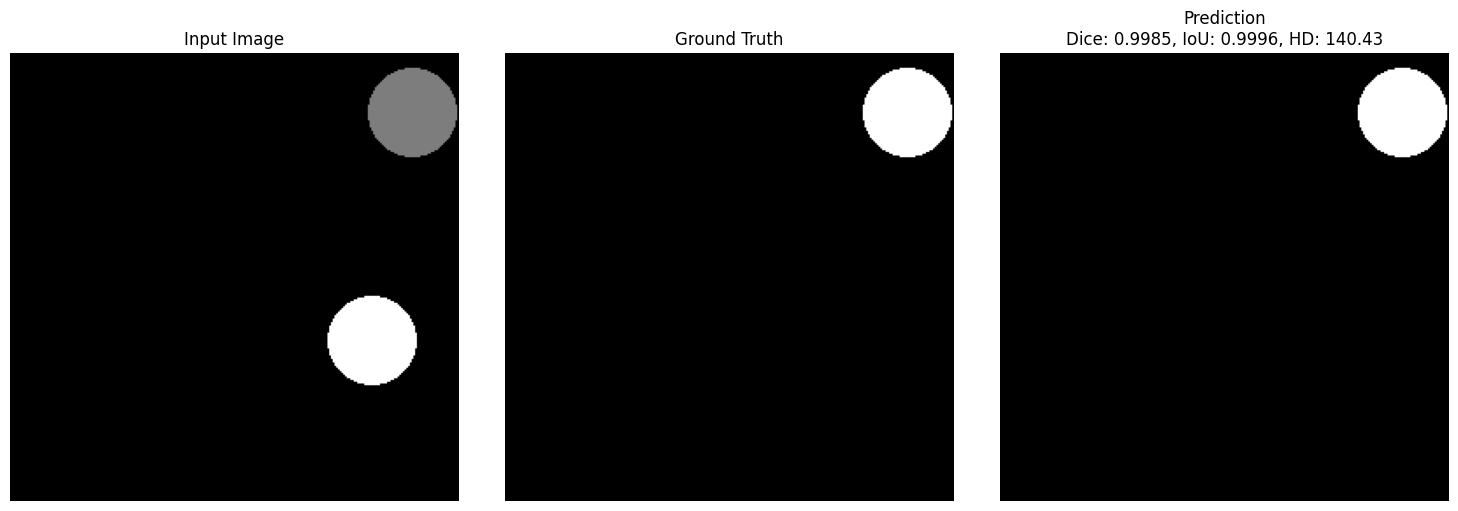

In [25]:
import matplotlib.pyplot as plt


# Visualize the segmentation along with the metrics
def visualize_segmentation(img, gt, pred, dice, iou, hd):
    # Convert tensor to numpy for visualization
    img_np = img[0, 0].cpu().numpy()  # First image in batch
    gt_np = gt[0].cpu().numpy()  # First ground truth in batch (binary mask)
    pred_np = pred[0].cpu().numpy()  # First predicted mask in batch

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(img_np, cmap="gray")
    axs[0].set_title("Input Image")

    axs[1].imshow(gt_np, cmap="gray")
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred_np, cmap="gray")
    axs[2].set_title(
        f"Prediction\nDice: {dice.mean().item():.4f}, IoU: {iou.item():.4f}, HD: {hd.item():.2f}"
    )

    for ax in axs:
        ax.axis("off")  # Turn off axes

    plt.tight_layout()
    plt.show()


# Call the visualization function
visualize_segmentation(img, gt_squeezed, pred_class_squeezed, dice, iou, hd)

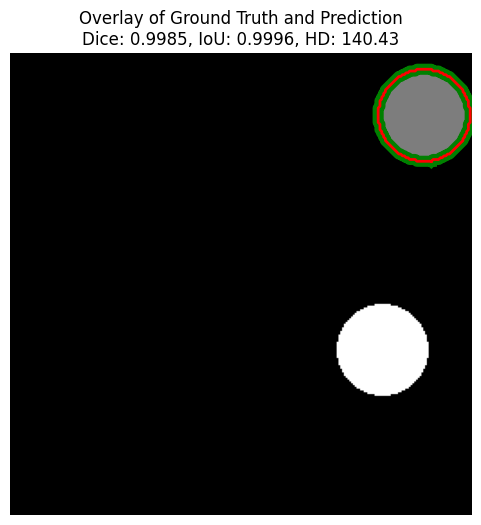

In [30]:
import matplotlib.pyplot as plt
from skimage import measure


# Overlay the contours of the prediction and ground truth on the input image
def visualize_contours(img, gt, pred):
    img_np = img[0, 0].cpu().numpy()  # First image in batch
    gt_np = gt[0].cpu().numpy()  # Ground truth mask
    pred_np = pred[0].cpu().numpy()  # Predicted mask

    # Get the contours of the ground truth and prediction
    gt_contours = measure.find_contours(gt_np, 0.5)
    pred_contours = measure.find_contours(pred_np, 0.5)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np, cmap="gray")  # Show the input image

    # Plot ground truth contours in green
    for contour in gt_contours:
        plt.plot(
            contour[:, 1],
            contour[:, 0],
            linewidth=8,
            color="green",
            label="Ground Truth",
        )

    # Plot predicted contours in red
    for contour in pred_contours:
        plt.plot(
            contour[:, 1], contour[:, 0], linewidth=2, color="red", label="Prediction"
        )

    plt.title(
        f"Overlay of Ground Truth and Prediction\nDice: {dice.mean().item():.4f}, IoU: {iou.item():.4f}, HD: {hd.item():.2f}"
    )
    plt.axis("off")
    plt.show()


# Call the function to visualize the contours
visualize_contours(img, gt_squeezed, pred_class_squeezed)

High Hausdorff Distance: The HD value is large because there is a significant spatial gap between the predicted circle and the second circle in the input image, even though this second circle is not part of the ground truth. HD measures the largest boundary mismatch, and the presence of the second circle in the input without corresponding predictions or ground truth could lead to this discrepancy.